# Demonstration of Omnistereo Sensor Implementation

In [1]:
# Imports for plotting and image display
from IPython.display import Image, display
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpldatacursor import datacursor, HighlightingDataCursor

from IPython.display import Image
import numpy as np
from sympy import Matrix, ImmutableMatrix
import os.path as osp
from omnistereo import common_tools
from omnistereo.common_cv import has_opencv
opencv_exists = has_opencv()

# Setup:
#===========================================================================
# vvvvvvvvvvvvvvvvvvvvvvv OPTIONS vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
# vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
is_synthetic = True
load_model_from_file = True  # <<< SETME: to load omnistereo model from a pickle or start anew
show_panoramic_img = True
show_3D_model = True
get_pointclouds = False
compute_new_3D_points = True
dense_cloud = True
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# vvvvvvvvvvvvvvvvvvvvvvv SETUP vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
# vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
#omnistereo_path = osp.relpath(common_tools.__file__)
data_root = "data" # The root folder for all data
model_version = "old"  # Set to "old" for the PUBLISHED params
data_path_prefix = osp.join(data_root, "synthetic", model_version)
experiment_name = "office"
experiment_path = osp.join(data_path_prefix, experiment_name)  # Pose estimation experiment: Translation on x only by 0, 25 cm and 75 cm (wrt init)

# For SHOWING OFF: virtual office
omni_img_filename_template = osp.join(experiment_path, "office-%s-*.png" % (model_version))  # With PUBLISHED parameters
# omni_img_filename_template = osp.join(data_path_prefix, experiment_path, "office" + model_version + "-*.png")  # NEW design
img_indices = []  # Choosing a predefined set of images to work with out of the set
img_index = 0  # <<<<<------ Choosing an arbitrary image to work with out of the set
# ------------------------------------------------
omnistereo_model_filename = osp.join(data_path_prefix, "omnistereo-hyperbolic.pkl")
# ------------------------------------------------
radial_bounds_filename = osp.join(data_path_prefix, "radial_bounds-" + model_version + ".pkl")  # Usually, this information is REUSABLE
# ------------------------------------------------
points_3D_filename_template = osp.join(experiment_path, "3d_points-" + model_version + "-*.pkl")
# Read params from file and scale to [mm] units since using [cm] (only those params with dimensions)
theoretical_params_filename = osp.join(data_root, "parameters-%s.txt" % (model_version))

Reading data/synthetic/old/office/office-old-0.png...success


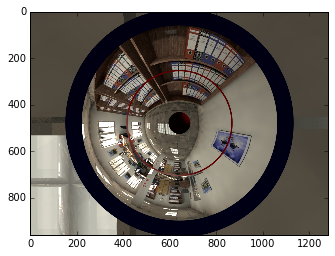

In [2]:
from omnistereo.common_cv import get_images
omni_images_list = get_images(omni_img_filename_template, indices_list=img_indices, show_images=False)
if has_opencv:
    from omnistereo.common_cv import get_cv_img_as_RGB
    omni_img_rgb = get_cv_img_as_RGB(omni_images_list[img_index])
    fig = plt.figure(figsize=(6,4))
    ax=fig.add_subplot(1,1,1)
    plt.imshow(omni_img_rgb)
    plt.show()

In [3]:
if load_model_from_file:
    omnistereo_model = common_tools.load_obj_from_pickle(omnistereo_model_filename)
else:
    # omni_img_filename = omni_img_filename_template.replace("*", str(img_index), 1)
    # omni_img = cv2.imread(omni_img_filename, 1)
    omni_img = omni_images_list[img_index]
    omnistereo_model = init_omnistereo_theoretical(omni_img, radial_bounds_filename, theoretical_params_filename, model_version, is_synthetic=is_synthetic)
    pano_width = np.pi * np.linalg.norm(omnistereo_model.bot_model.lowest_img_point - omnistereo_model.bot_model.precalib_params.center_point)
    omnistereo_model.set_current_omni_image(omni_img, pano_width_in_pixels=pano_width, generate_panoramas=True, idx=img_index, view=True)
    common_tools.save_obj_in_pickle(omnistereo_model, omnistereo_model_filename, locals())

Loading obj_instance instance from pickle file data/synthetic/old/omnistereo-hyperbolic.pkl ... done!


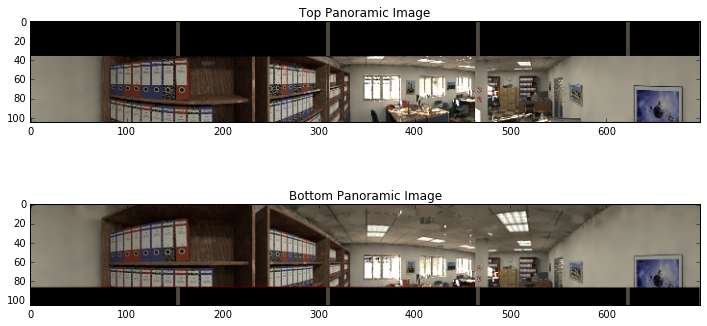

In [4]:
if show_panoramic_img and opencv_exists:
    #omnistereo_model.view_all_panoramas(omni_img_filename_template, img_indices, win_name_modifier=pano_win_name_prefix, use_mask=True, mask_color_RGB=(0, 255, 0))
    pano_img_top, pano_img_bot = omnistereo_model.generate_panorama_pair(omni_img=omni_images_list[img_index], idx=img_index, view=False, win_name_modifier="", border_RGB_color=None)
    # Convert panoramic images to RGB:
    pano_img_top_rgb = get_cv_img_as_RGB(pano_img_top)
    pano_img_bot_rgb = get_cv_img_as_RGB(pano_img_bot)
    # Display images
    fig = plt.figure(figsize=(12,6))
    ax=fig.add_subplot(2,1,1)
    imgplot = plt.imshow(pano_img_top_rgb)
    ax.set_title('Top Panoramic Image')
    #plt.colorbar(ticks=[0.1,0.3,0.5,0.7], orientation ='horizontal')
    ax=fig.add_subplot(2,1,2)
    imgplot = plt.imshow(pano_img_bot_rgb)
    #imgplot.set_clim(0.0,0.7)
    ax.set_title('Bottom Panoramic Image')
    #plt.colorbar(ticks=[0.1,0.3,0.5,0.7], orientation='horizontal')

In [6]:
#from omnistereo.common_plot import draw_omnistereo_model_visvis
#draw_omnistereo_model_visvis(omnistereo_model, finish_drawing=True, show_grid_box=False, mirror_transparency=0.5, show_reference_frame=True)

In [7]:
# TODO: VisPy not working with webGL backend in version 4.
# load the vispy bindings for the IPython notebook which enables webGL
# %load_ext vispy.ipython
#from omnistereo.common_plot import draw_omnistereo_model_vispy
#draw_omnistereo_model_vispy(omnistereo_model, show_grid=True, backend='ipynb_webgl')

## 2D Plots for Analysis

In [8]:
# TODO: 2D Plots